## Import Relevant Files

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import json

from IPython.display import Audio

import sys
sys.path.insert(1, '../utils')
from paths import *

sys.path.insert(1, '../models')
from feedforward_nn_combined import NeuralNetworkCombined
from pprint import pprint

import chromadb

## Load Music Metadata

In [2]:
# Skipped DEAM 2014 because metadata.csv is corrupted

df_music_deam_2013 = pd.read_csv('../../data/DEAM/metadata/metadata_2013.csv')

df_music_pmemo = pd.read_csv('../../data/PMEmo/PMEmo2019/metadata.csv')

In [3]:
def strip_values(value):
    value = value.strip()
    return value

In [4]:
df_music_deam_2013_copy = df_music_deam_2013.copy()
df_music_deam_2013_copy['file_path'] = df_music_deam_2013_copy['song_id'].apply(lambda x: f'../../data/DEAM/MEMD_audio/{x}.mp3')
df_music_deam_2013_copy['song_id'] = df_music_deam_2013_copy['song_id'].apply(lambda x: f'deam_{x}')
df_music_deam_2013_copy = df_music_deam_2013_copy.drop(columns=["start of the segment (min.sec)", "end of the segment (min.sec)", "file_name", "Genre"])

df_music_deam_2013_copy.rename(columns={"Artist": "artist", "Song title": "title"}, inplace=True)

cols = df_music_deam_2013_copy.columns.tolist()

for col in cols:
    df_music_deam_2013_copy[col] = df_music_deam_2013_copy[col].map(strip_values)

display(df_music_deam_2013_copy)

song_id                                 artist  \
0       deam_2           The New Mystikal Troubadours   
1       deam_3                          Kevin MacLeod   
2       deam_4                          Kevin MacLeod   
3       deam_5                          My Bubba & Mi   
4       deam_7                          Kevin MacLeod   
..         ...                                    ...   
739   deam_995                          Benjamin Bret   
740   deam_996                                Jahzzar   
741   deam_997                              Halloween   
742   deam_999                                Jahzzar   
743  deam_1000  Republic Of Lights-Got You Surrounded   

                         title                            file_path  
0    Tonight  A Lonely Century     ../../data/DEAM/MEMD_audio/2.mp3  
1                    DD Groove     ../../data/DEAM/MEMD_audio/3.mp3  
2                    Slow Burn     ../../data/DEAM/MEMD_audio/4.mp3  
3                 Nothing Much     ../../data/DEAM/MEMD_audio/5.mp3  
4                       Hustle     ../../data/DEAM/MEMD_audio/7.mp3  
..                         ...                                  ...  
739               Honte De Toi   ../../data/DEAM/MEMD_audio/995.mp3  
740                  Fireworks   ../../data/DEAM/MEMD_audio/996.mp3  
741          Monster On Campus   ../../data/DEAM/MEMD_audio/997.mp3  
742                    So Easy   ../../data/DEAM/MEMD_audio/999.mp3  
743                     Single  ../../data/DEAM/MEMD_audio/1000.mp3  

[744 rows x 4 columns]

In [5]:
df_pmemo_annotations = pd.read_csv('../../data/PMEmo/PMEmo2019/processed/annotations/pmemo_static_annotations.csv')
pmemo_song_ids = df_pmemo_annotations['song_id'].tolist()
print(pmemo_song_ids)

[1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 119, 120, 123, 124, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 179, 180, 181, 184, 185, 186, 187, 188, 189, 191, 192, 196, 197, 198, 199, 200, 201, 202, 203, 204, 207, 209, 210, 211, 212, 213, 215, 216, 217, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 244, 249, 251, 252, 253, 257, 258, 260, 263, 265, 267, 269, 273, 275, 276, 277, 279, 280, 282, 283, 284, 285, 287,

In [6]:
df_music_pmemo_copy = df_music_pmemo.copy()
df_music_pmemo_copy = df_music_pmemo_copy[df_music_pmemo_copy['musicId'].isin(pmemo_song_ids)]
df_music_pmemo_copy['file_path'] = df_music_pmemo_copy['musicId'].apply(lambda x: f'../../data/PMEmo/PMEmo2019/chorus/{x}.mp3')
df_music_pmemo_copy['song_id'] = df_music_pmemo['musicId'].apply(lambda x: f'pmemo_{x}')
df_music_pmemo_copy = df_music_pmemo_copy.drop(columns=["musicId", "fileName", "album", "duration", "chorus_start_time", "chorus_end_time"])

df_music_pmemo_copy = df_music_pmemo_copy[cols]
display(df_music_pmemo_copy)

song_id               artist  \
0       pmemo_1             2 Chainz   
1       pmemo_4            21 Savage   
2       pmemo_5            21 Savage   
3       pmemo_6            21 Savage   
4       pmemo_7  5 Seconds Of Summer   
..          ...                  ...   
789   pmemo_993                 Zedd   
790   pmemo_996              offaiah   
791   pmemo_997                방탄소년단   
792   pmemo_999                방탄소년단   
793  pmemo_1000                방탄소년단   

                                            title  \
0                                      Good Drank   
1                          X Bitch (feat. Future)   
2                                        No Heart   
3                                        Red Opps   
4                                 Girls Talk Boys   
..                                            ...   
789                                          Stay   
790                                       Trouble   
791  A Supplementary Story : You Never Walk Alone   
792                                 Outro : Wings   
793                                    Spring Day   

                                      file_path  
0       ../../data/PMEmo/PMEmo2019/chorus/1.mp3  
1       ../../data/PMEmo/PMEmo2019/chorus/4.mp3  
2       ../../data/PMEmo/PMEmo2019/chorus/5.mp3  
3       ../../data/PMEmo/PMEmo2019/chorus/6.mp3  
4       ../../data/PMEmo/PMEmo2019/chorus/7.mp3  
..                                          ...  
789   ../../data/PMEmo/PMEmo2019/chorus/993.mp3  
790   ../../data/PMEmo/PMEmo2019/chorus/996.mp3  
791   ../../data/PMEmo/PMEmo2019/chorus/997.mp3  
792   ../../data/PMEmo/PMEmo2019/chorus/999.mp3  
793  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3  

[767 rows x 4 columns]

In [7]:
df_music = pd.concat([df_music_deam_2013_copy, df_music_pmemo_copy], axis=0)

display(df_music)

song_id                        artist  \
0        deam_2  The New Mystikal Troubadours   
1        deam_3                 Kevin MacLeod   
2        deam_4                 Kevin MacLeod   
3        deam_5                 My Bubba & Mi   
4        deam_7                 Kevin MacLeod   
..          ...                           ...   
789   pmemo_993                          Zedd   
790   pmemo_996                       offaiah   
791   pmemo_997                         방탄소년단   
792   pmemo_999                         방탄소년단   
793  pmemo_1000                         방탄소년단   

                                            title  \
0                       Tonight  A Lonely Century   
1                                       DD Groove   
2                                       Slow Burn   
3                                    Nothing Much   
4                                          Hustle   
..                                            ...   
789                                          Stay   
790                                       Trouble   
791  A Supplementary Story : You Never Walk Alone   
792                                 Outro : Wings   
793                                    Spring Day   

                                      file_path  
0              ../../data/DEAM/MEMD_audio/2.mp3  
1              ../../data/DEAM/MEMD_audio/3.mp3  
2              ../../data/DEAM/MEMD_audio/4.mp3  
3              ../../data/DEAM/MEMD_audio/5.mp3  
4              ../../data/DEAM/MEMD_audio/7.mp3  
..                                          ...  
789   ../../data/PMEmo/PMEmo2019/chorus/993.mp3  
790   ../../data/PMEmo/PMEmo2019/chorus/996.mp3  
791   ../../data/PMEmo/PMEmo2019/chorus/997.mp3  
792   ../../data/PMEmo/PMEmo2019/chorus/999.mp3  
793  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3  

[1511 rows x 4 columns]

## Load Opensmile Features

In [8]:
df_features = pd.read_csv("../../data/combined/features/opensmile_gemaps_features.csv")
display(df_features)

song_id  F0semitoneFrom27.5Hz_sma3nz_amean  \
0         deam_2                          22.932022   
1         deam_3                          16.164516   
2         deam_4                          22.580710   
3         deam_5                          29.905169   
4         deam_7                          18.706436   
...          ...                                ...   
2506   pmemo_993                          28.589037   
2507   pmemo_996                          34.963680   
2508   pmemo_997                          23.521826   
2509   pmemo_999                          28.412848   
2510  pmemo_1000                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
2506                                0.445477   
2507                                0.308940   
2508                                0.515144   
2509                                0.529474   
2510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
2506                                   16.152197   
2507                                   23.050102   
2508                                   13.664935   
2509                                   14.129504   
2510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
2506                                   24.940647   
2507                                   39.976578   
2508                                   16.773577   
2509                                   21.055300   
2510                                   23.073471   

      F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                      24.485361   
1                                      18.985416   
2                                      24.116590   
3                                      37.959970   
4                                      21.956436   
...                                          ...   
2506                                   44.368267   
2507                                   43.117737   
2508                                   37.080620   
2509                                   48.873077   
2510                                   44.002636   

      F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                     4.829792   
1                                     4.884358   
2                                     8.062586   
3                                    15.572155   
4                                     6.759335   
...                                        ...   
2506                                 28.216070   
2507                                 20.067635   
2508                                 23.415684   
2509                                 34.743572   
2510                                 29.877811   

      F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                      124.252335   
1                                       85.965515   
2                                      299.053960   
3                                      179.485930   
4                             

In [9]:
df_combined = df_music.merge(df_features, how="inner", on="song_id")
display(df_combined)

song_id                        artist  \
0         deam_2  The New Mystikal Troubadours   
1         deam_3                 Kevin MacLeod   
2         deam_4                 Kevin MacLeod   
3         deam_5                 My Bubba & Mi   
4         deam_7                 Kevin MacLeod   
...          ...                           ...   
1506   pmemo_993                          Zedd   
1507   pmemo_996                       offaiah   
1508   pmemo_997                         방탄소년단   
1509   pmemo_999                         방탄소년단   
1510  pmemo_1000                         방탄소년단   

                                             title  \
0                        Tonight  A Lonely Century   
1                                        DD Groove   
2                                        Slow Burn   
3                                     Nothing Much   
4                                           Hustle   
...                                            ...   
1506                                          Stay   
1507                                       Trouble   
1508  A Supplementary Story : You Never Walk Alone   
1509                                 Outro : Wings   
1510                                    Spring Day   

                                       file_path  \
0               ../../data/DEAM/MEMD_audio/2.mp3   
1               ../../data/DEAM/MEMD_audio/3.mp3   
2               ../../data/DEAM/MEMD_audio/4.mp3   
3               ../../data/DEAM/MEMD_audio/5.mp3   
4               ../../data/DEAM/MEMD_audio/7.mp3   
...                                          ...   
1506   ../../data/PMEmo/PMEmo2019/chorus/993.mp3   
1507   ../../data/PMEmo/PMEmo2019/chorus/996.mp3   
1508   ../../data/PMEmo/PMEmo2019/chorus/997.mp3   
1509   ../../data/PMEmo/PMEmo2019/chorus/999.mp3   
1510  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3   

      F0semitoneFrom27.5Hz_sma3nz_amean  \
0                             22.932022   
1                             16.164516   
2                             22.580710   
3                             29.905169   
4                             18.706436   
...                                 ...   
1506                          28.589037   
1507                          34.963680   
1508                          23.521826   
1509                          28.412848   
1510                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
1506                                0.445477   
1507                                0.308940   
1508                                0.515144   
1509                                0.529474   
1510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
1506                                   16.152197   
1507                                   23.050102   
1508                                   13.664935   
1509                                   14.129504   
1510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
1506                                   24.940647   

In [10]:
with open("../models/opensmile_gemaps_normalised/config.json") as file:
    config = json.load(file)

In [11]:
pprint(config)

{'columns': ['F0semitoneFrom27.5Hz_sma3nz_amean',
             'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
             'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
             'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
             'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
             'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
             'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
             'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
             'loudness_sma3_amean',
             'loudness_sma3_stddevNorm',
             'loudness_sma3_percentile20.0',
             'loudness_sma3_percentile50.0',
             'loudness_sma3_percentile80.0',
             'loudness_sma3_pctlrange0-2',
             'loudness_sma3_meanRisingSlope',
             'loudness_sma3_stddevRisingSlope',
             'loudness_sma3_meanFallingSlope',
             'loudn

In [12]:
feature_cols = config["columns"]

pprint(feature_cols)

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'shimmerLocaldB_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'HNRdBACF_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3

In [13]:
scaler_fpath = config["scaler"]
# print(scaler_fpath)
scaler_fpath = scaler_fpath.replace(".", "../..", 1)
scaler = joblib.load(scaler_fpath) #MinMaxScaler

In [14]:
input_size = len(config["columns"])
print(input_size)
weights_fpath = config["model_weights"]
weights_fpath = weights_fpath.replace(".", "../..", 1)

model = NeuralNetworkCombined(input_size)
model.load_state_dict(torch.load(weights_fpath))

62


<All keys matched successfully>

In [15]:
inputs_normalised = scaler.transform(df_combined[config["columns"]].values)
inputs = torch.tensor(inputs_normalised).float()
print(inputs)

tensor([[0.2031, 0.2290, 0.1763,  ..., 0.1645, 0.0263, 0.0142],
        [0.0456, 0.2126, 0.0472,  ..., 0.0244, 0.0741, 0.0568],
        [0.1949, 0.4419, 0.0926,  ..., 0.0186, 0.0389, 0.0180],
        ...,
        [0.2169, 0.7255, 0.0370,  ..., 0.0141, 0.0801, 0.1361],
        [0.3307, 0.7473, 0.0478,  ..., 0.0133, 0.0998, 0.2008],
        [0.3309, 0.6502, 0.0477,  ..., 0.0098, 0.1009, 0.1005]])


/Users/issacj/Desktop/Personal/SUTD/School Year/Year 3/Term 6/50.038 Computational Data Science/Project/CDeeS/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [16]:
preds = model(inputs)
print(preds)

tensor([[-0.0734, -0.1276],
        [-0.2044, -0.0619],
        [ 0.2093,  0.2068],
        ...,
        [ 0.2965,  0.4219],
        [ 0.6122,  0.7555],
        [ 0.5335,  0.6505]], grad_fn=<TanhBackward0>)


In [17]:
# Pretend to keep only VA values - Used dummy variables instead
df_combined["valence_pred"] = preds[:, 0].detach().numpy()
df_combined["arousal_pred"] = preds[:, 1].detach().numpy()
display(df_combined)

song_id                        artist  \
0         deam_2  The New Mystikal Troubadours   
1         deam_3                 Kevin MacLeod   
2         deam_4                 Kevin MacLeod   
3         deam_5                 My Bubba & Mi   
4         deam_7                 Kevin MacLeod   
...          ...                           ...   
1506   pmemo_993                          Zedd   
1507   pmemo_996                       offaiah   
1508   pmemo_997                         방탄소년단   
1509   pmemo_999                         방탄소년단   
1510  pmemo_1000                         방탄소년단   

                                             title  \
0                        Tonight  A Lonely Century   
1                                        DD Groove   
2                                        Slow Burn   
3                                     Nothing Much   
4                                           Hustle   
...                                            ...   
1506                                          Stay   
1507                                       Trouble   
1508  A Supplementary Story : You Never Walk Alone   
1509                                 Outro : Wings   
1510                                    Spring Day   

                                       file_path  \
0               ../../data/DEAM/MEMD_audio/2.mp3   
1               ../../data/DEAM/MEMD_audio/3.mp3   
2               ../../data/DEAM/MEMD_audio/4.mp3   
3               ../../data/DEAM/MEMD_audio/5.mp3   
4               ../../data/DEAM/MEMD_audio/7.mp3   
...                                          ...   
1506   ../../data/PMEmo/PMEmo2019/chorus/993.mp3   
1507   ../../data/PMEmo/PMEmo2019/chorus/996.mp3   
1508   ../../data/PMEmo/PMEmo2019/chorus/997.mp3   
1509   ../../data/PMEmo/PMEmo2019/chorus/999.mp3   
1510  ../../data/PMEmo/PMEmo2019/chorus/1000.mp3   

      F0semitoneFrom27.5Hz_sma3nz_amean  \
0                             22.932022   
1                             16.164516   
2                             22.580710   
3                             29.905169   
4                             18.706436   
...                                 ...   
1506                          28.589037   
1507                          34.963680   
1508                          23.521826   
1509                          28.412848   
1510                          28.422981   

      F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                   0.189338   
1                                   0.178617   
2                                   0.329062   
3                                   0.264543   
4                                   0.172212   
...                                      ...   
1506                                0.445477   
1507                                0.308940   
1508                                0.515144   
1509                                0.529474   
1510                                0.465772   

      F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                      19.655570   
1                                      14.101058   
2                                      16.054005   
3                                      22.387814   
4                                      15.197102   
...                                          ...   
1506                                   16.152197   
1507                                   23.050102   
1508                                   13.664935   
1509                                   14.129504   
1510                                   14.124825   

      F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                      23.607199   
1                                      15.239481   
2                                      23.823282   
3                                      30.137478   
4                                      18.928482   
...                                          ...   
1506                                   24.940647   

In [18]:
df_va = df_combined[["valence_pred", "arousal_pred"]].copy()
display(df_va.values.tolist())

[[-0.07338837534189224, -0.1276376098394394],
 [-0.20439529418945312, -0.06186279281973839],
 [0.20931197702884674, 0.20675651729106903],
 [0.06673110276460648, -0.21515502035617828],
 [0.07614307850599289, 0.2650906443595886],
 [-0.16405338048934937, -0.22950097918510437],
 [-0.18361538648605347, -0.25756338238716125],
 [0.22818326950073242, 0.2879182696342468],
 [-0.21645154058933258, -0.3381359279155731],
 [0.18282552063465118, 0.2547813653945923],
 [-0.1677337884902954, -0.14065274596214294],
 [-0.01641395315527916, -0.2541503608226776],
 [0.28933224081993103, 0.2588631510734558],
 [0.16527754068374634, 0.2465427666902542],
 [-0.027322731912136078, -0.017884299159049988],
 [0.03422003239393234, 0.10198088735342026],
 [0.17148429155349731, 0.036778826266527176],
 [0.13872088491916656, 0.11351993680000305],
 [0.044606007635593414, -0.07449808716773987],
 [0.07592610269784927, 0.23364867269992828],
 [0.20255620777606964, 0.000177726149559021],
 [0.3322659432888031, 0.33017751574516296

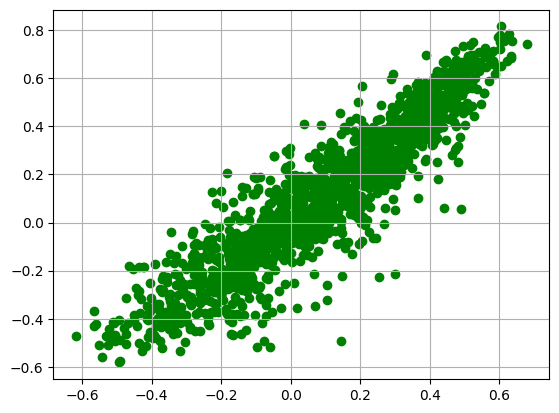

In [19]:
plt.scatter(df_combined["valence_pred"], df_combined["arousal_pred"], c="green")
plt.grid(True)
plt.show()

In [20]:
metadata = df_combined.columns.tolist()[1:3]
metadata_dicts = df_combined[metadata].to_dict('records')
pprint(metadata_dicts)

[{'artist': 'The New Mystikal Troubadours',
  'title': 'Tonight  A Lonely Century'},
 {'artist': 'Kevin MacLeod', 'title': 'DD Groove'},
 {'artist': 'Kevin MacLeod', 'title': 'Slow Burn'},
 {'artist': 'My Bubba & Mi', 'title': 'Nothing Much'},
 {'artist': 'Kevin MacLeod', 'title': 'Hustle'},
 {'artist': 'Kevin MacLeod', 'title': 'Dirt Rhodes'},
 {'artist': 'Arne Bang Huseby', 'title': 'Stormy Blues'},
 {'artist': 'Sul Rebel', 'title': 'Rebel Blues'},
 {'artist': 'My Bubba & Mi', 'title': 'Oh Kiss No'},
 {'artist': 'Phoephus', 'title': 'Fjcb Reddit Gtr Fills Mix'},
 {'artist': 'Black Rebel Motorcycle Club',
  'title': "Beat The Devil's Tattoo (Live @ KEXP)"},
 {'artist': "WHO'S PANDA", 'title': 'Vultures'},
 {'artist': "Stevie's Amp Shack",
  'title': 'Blues Shuffle in A One Take Improv Exercise'},
 {'artist': 'Cian Nugent', 'title': 'My War Blues'},
 {'artist': 'The New Mystikal Troubadours', 'title': 'The Holy Feele'},
 {'artist': 'Bombay Laughing Club', 'title': 'Workin Boy Blues'},


In [21]:
song_ids = df_combined["song_id"].values.tolist()
print(song_ids)

['deam_2', 'deam_3', 'deam_4', 'deam_5', 'deam_7', 'deam_8', 'deam_10', 'deam_12', 'deam_13', 'deam_17', 'deam_18', 'deam_19', 'deam_20', 'deam_21', 'deam_22', 'deam_24', 'deam_25', 'deam_31', 'deam_32', 'deam_35', 'deam_37', 'deam_39', 'deam_40', 'deam_41', 'deam_42', 'deam_43', 'deam_44', 'deam_45', 'deam_46', 'deam_47', 'deam_48', 'deam_49', 'deam_50', 'deam_51', 'deam_52', 'deam_53', 'deam_54', 'deam_55', 'deam_56', 'deam_58', 'deam_59', 'deam_60', 'deam_62', 'deam_64', 'deam_65', 'deam_67', 'deam_68', 'deam_69', 'deam_70', 'deam_71', 'deam_72', 'deam_73', 'deam_74', 'deam_76', 'deam_77', 'deam_78', 'deam_79', 'deam_80', 'deam_81', 'deam_82', 'deam_83', 'deam_84', 'deam_85', 'deam_86', 'deam_87', 'deam_88', 'deam_89', 'deam_90', 'deam_91', 'deam_92', 'deam_93', 'deam_95', 'deam_96', 'deam_98', 'deam_99', 'deam_101', 'deam_102', 'deam_103', 'deam_104', 'deam_105', 'deam_106', 'deam_107', 'deam_108', 'deam_109', 'deam_110', 'deam_111', 'deam_112', 'deam_113', 'deam_114', 'deam_115', 

In [22]:
fpath_list = df_combined["file_path"].values.tolist()

## Chroma Vector Database

In [23]:
client = chromadb.Client()

## Persistent store
# client = chromadb.PersistentClient(path="./db/")

client.heartbeat()


1712720830950589000

In [24]:
# https://docs.trychroma.com/usage-guide#changing-the-distance-function
collection = client.create_collection(
        name="DEAM_PMEmo_dataset",
        metadata={"hnsw:space": "l2"} # "l2", "ip" or "cosine"
    )

In [25]:
collection.add(
    documents=fpath_list, # file_path
    embeddings=df_va.values.tolist(), # VA embeddings
    metadatas=metadata_dicts, # song_names, artist
    ids=song_ids # song_id from SiTunes dataset
)

In [26]:
# Set number of results to return
k = 5

In [34]:
res = collection.query(
    query_embeddings=[[1, 1]], # search by embeddings
    n_results=k, # number of results
    # where={"metadata_field": "is_equal_to_this"}, # filter on metadata, e.g. genre
    # where_document={"$contains":"search_string"} # filter on file path???
    # include=["distances", "metadatas", "embeddings", "documents", "uris", "data"] # Need to include all relevant parameters to show
    include=["distances", "metadatas", "embeddings", "documents"]
    )

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'artist': 'Lady GaGa', 'title': 'Applause'} ../../data/PMEmo/PMEmo2019/chorus/567.mp3


In [31]:
res = collection.query(
    query_embeddings=[[-1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'artist': 'The Ghost Of 29 Megacycles', 'title': 'Leelo (Part 1)'} ../../data/DEAM/MEMD_audio/945.mp3


In [32]:
res = collection.query(
    query_embeddings=[[-1, 1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'artist': 'Drake', 'title': 'Free Smoke'} ../../data/PMEmo/PMEmo2019/chorus/253.mp3


In [36]:
res = collection.query(
    query_embeddings=[[1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

pprint(res)

{'data': None,
 'distances': [[0.9905972480773926,
                1.1106339693069458,
                1.1587066650390625,
                1.2649438381195068,
                1.2900164127349854]],
 'documents': [['../../data/DEAM/MEMD_audio/456.mp3',
                '../../data/DEAM/MEMD_audio/977.mp3',
                '../../data/DEAM/MEMD_audio/45.mp3',
                '../../data/DEAM/MEMD_audio/330.mp3',
                '../../data/DEAM/MEMD_audio/104.mp3']],
 'embeddings': [[[0.14440837502479553, -0.49151188135147095],
                 [0.2994464635848999, -0.21268893778324127],
                 [0.2522721290588379, -0.22565536201000214],
                 [0.10312969982624054, -0.32134881615638733],
                 [0.06973781436681747, -0.3483647108078003]]],
 'ids': [['deam_456', 'deam_977', 'deam_45', 'deam_330', 'deam_104']],
 'metadatas': [[{'artist': 'Stickfigure', 'title': 'Crack in Time'},
                {'artist': 'Black Math', 'title': 'Suck City'},
                {'a

In [37]:
metadata = res["metadatas"][0][1]
fpath = res["documents"][0][1]
print(metadata, fpath)

Audio(fpath)

{'artist': 'Black Math', 'title': 'Suck City'} ../../data/DEAM/MEMD_audio/977.mp3


In [33]:
res = collection.query(
    query_embeddings=[[0, 0]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings", "documents"]
)

metadata = res["metadatas"][0][0]
fpath = res["documents"][0][0]
print(metadata, fpath)

Audio(fpath)

{'artist': 'Jason Shaw', 'title': '12 MORNINGS'} ../../data/DEAM/MEMD_audio/582.mp3
